# Imports

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from pathlib import Path
from PIL import Image
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/home/salkhon/miniconda3/envs/general/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
class ImageDataset(Dataset):
    def __init__(self, root: Path):
        self.data_dir = root
        self.data_paths = list(self.data_dir.rglob("*.jpg"))

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Read an image and convert it to black and white

        Args:
            idx (int): Image index

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Black and white image and rgb color space image
        """
        with Image.open(self.data_paths[idx]).resize((256, 256)) as img:
            rgb_img = transforms.ToTensor()(img.convert("RGB"))  # (3, 256, 256)
            bw_img = transforms.ToTensor()(img.convert("L"))  # (1, 256, 256)
            bw_img = bw_img.repeat(3, 1, 1)  # (3, 256, 256)

        return bw_img, rgb_img

# Base Model

In [3]:
class Block(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, upsample=1):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.Tanh()  # todo: change to ReLU
        self.upsample = torch.nn.Upsample(scale_factor=upsample)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.upsample(self.relu(self.bn(self.conv(x))))

In [4]:
class ConvNetWithEfficientNetFeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # EfficientNetB7 feature extractor (frozen)
        self.FEATURE_EXTRACTOR_LAYERS = 9
        self.feature_extractor = efficientnet_b7(
            weights=EfficientNet_B7_Weights.IMAGENET1K_V1
        ).features
        self.feature_extractor.requires_grad_(False)
        # Colorization layers (Conv2d, BatchNorm2d, ReLU, Upsample, Conv2d)
        self.colorization_layers = torch.nn.Sequential(
            Block(2560, 640),
            Block(640, 384),
            Block(384, 224, upsample=2),
            Block(224, 160),
            Block(160, 80, upsample=2),
            Block(80, 48, upsample=2),
            Block(48, 32, upsample=2),
            Block(32, 64, upsample=2),
            torch.nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            torch.nn.Tanh(),  # todo: should have been sigmoid for RGB
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feature32 = self.feature_extractor[0:2](
            x
        )  # 3x256x256 -> 64x128x128 -> 32x128x128
        feature48 = self.feature_extractor[2](feature32)  # 32x128x128 -> 48x64x64
        feature80 = self.feature_extractor[3](feature48)  # 48x64x64 -> 80x32x32
        feature224 = self.feature_extractor[4:6](
            feature80
        )  # 80x32x32 -> 160x16x16 -> 224x16x16
        feature640 = self.feature_extractor[6:8](
            feature224
        )  # 224x16x16 -> 384x8x8 -> 640x8x8
        feature2560 = self.feature_extractor[8](feature640)  # 640x8x8 -> 2560x8x8

        out = self.colorization_layers[0](feature2560)  # 2560x8x8 -> 640x16x16
        out += feature640
        out = self.colorization_layers[1:3](out)  # 640x16x16 -> 384x32x32 -> 224x32x32
        out += feature224
        out = self.colorization_layers[3:5](out)  # 224x32x32 -> 160x64x64 -> 80x64x64
        out += feature80
        out = self.colorization_layers[5](out)  # 80x64x64 -> 48x128x128
        out += feature48
        out = self.colorization_layers[6](out)  # 48x128x128 -> 32x256x256
        out += feature32
        out = self.colorization_layers[7:10](
            out
        )  # 32x256x256 -> 64x256x256 -> 2x256x256

        return out

In [5]:
model = ConvNetWithEfficientNetFeatureExtractor().to("cuda")

# Inference

In [6]:
model.load_state_dict(torch.load("/home/salkhon/repo/colorization/models/model.pth"))

<All keys matched successfully>

In [7]:
davis_bear_ds = ImageDataset(Path("/home/salkhon/repo/colorization/data/DAVIS/JPEGImages/480p/bear"))

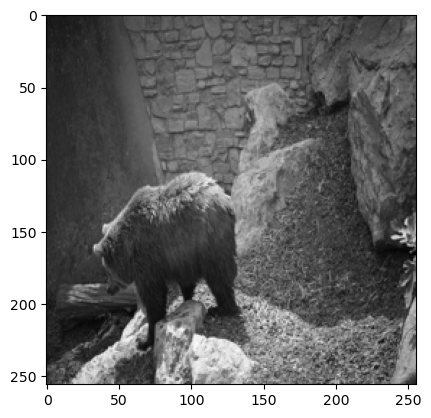

In [8]:
plt.imshow(davis_bear_ds[0][0].permute(1, 2, 0))

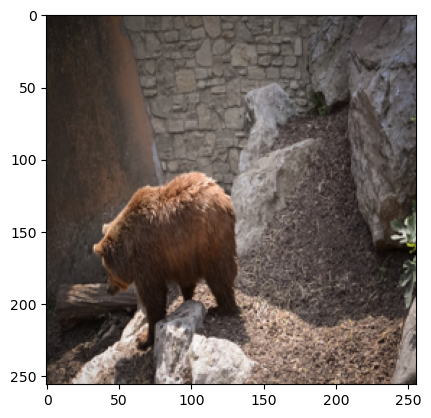

In [9]:
plt.imshow(davis_bear_ds[0][1].permute(1, 2, 0))

In [10]:
inp = davis_bear_ds[0][0].unsqueeze(0).to("cuda")
out = model(inp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


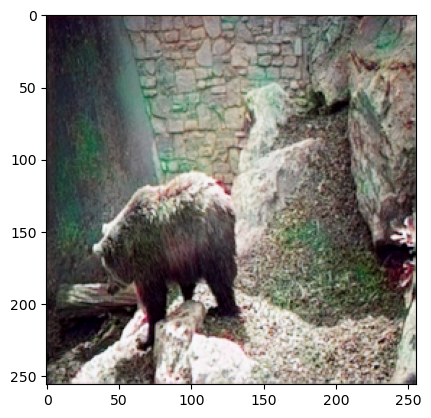

In [11]:
out: torch.Tensor
out = out.detach()[0].cpu()
plt.imshow(out.permute(1, 2, 0))

## Inference on DAVIS dataset

In [12]:
DAVIS_PATH = Path("/home/salkhon/repo/colorization/data/DAVIS/JPEGImages/480p/")
OUTPUT_PATH = Path("/home/salkhon/repo/colorization/output")

In [13]:
davis_ds = ImageDataset(DAVIS_PATH)

In [14]:
for img_idx in tqdm(range(len(davis_ds))):
    inp = davis_ds[img_idx][0].unsqueeze(0).to("cuda")
    out = model(inp)
    out: torch.Tensor = out.detach()[0].cpu()
    # save on appropriate subdir
    out = torch.clip(out, 0, 1)
    inp_path = davis_ds.data_paths[img_idx]
    out_path = OUTPUT_PATH / inp_path.relative_to(DAVIS_PATH)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    transforms.ToPILImage()(out).save(out_path)

100%|██████████| 6208/6208 [22:57<00:00,  4.51it/s]


In [18]:
# Function to compute PSNR between two images
def psnr(img1: torch.Tensor, img2: torch.Tensor) -> float:
    mse = torch.mean((img1 - img2) ** 2)
    return (20 * torch.log10(1.0 / torch.sqrt(mse))).squeeze().item()

In [19]:
gt = davis_ds[0][1]
out = model(davis_ds[0][0].unsqueeze(0).to("cuda"))
out: torch.Tensor
out = out.detach()[0].cpu()
psnr_val = psnr(gt, out)
print(psnr_val)

24.624717712402344
